# Speedtest Data from Ookla

This example will use data collected from Ookla's Speed Test application and [shared publicly in the AWS Open Data Registry](https://registry.opendata.aws/speedtest-global-performance/). From the AWS page:

> Global fixed broadband and mobile (cellular) network performance, allocated to zoom level 16 web mercator tiles (approximately 610.8 meters by 610.8 meters at the equator). Data is provided in both Shapefile format as well as Apache Parquet with geometries represented in Well Known Text (WKT) projected in EPSG:4326. Download speed, upload speed, and latency are collected via the Speedtest by Ookla applications for Android and iOS and averaged for each tile.

## Imports

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from palettable.colorbrewer.diverging import BrBG_10

from lonboard import ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap

The URL for a single data file for mobile network speeds in the first quarter of 2019.

In [2]:
url = "https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2019/quarter=1/2019-01-01_performance_mobile_tiles.parquet"

We can fetch two columns from this data file directly from AWS. This `pd.read_parquet` command will perform a network request for the data file, so it may take a while on a slow network connection.

In [3]:
# avg_d_kbps is the average download speed for that data point in kilobits per second
# tile is the WKT string representing a given zoom-16 Web Mercator tile
columns = ["avg_d_kbps", "tile"]

In [4]:
df = pd.read_parquet(url, columns=columns)

We can take a quick look at this data:

In [5]:
df.head()

,avg_d_kbps,tile
0,5983,"POLYGON((-160.021362304688 70.6381267305321, -..."
1,3748,"POLYGON((-160.043334960938 70.6344840663086, -..."
2,3364,"POLYGON((-160.043334960938 70.6326624870732, -..."
3,2381,"POLYGON((-160.037841796875 70.6344840663086, -..."
4,3047,"POLYGON((-160.037841796875 70.6326624870732, -..."


The `tile` column contains _strings_ representing geometries. We need to parse those strings into geometries. Then for simplicity we'll convert into their centroids.

In [6]:
tile_geometries = shapely.from_wkt(df["tile"])
tile_centroids = shapely.centroid(tile_geometries)

Now we can create a geopandas GeoDataFrame from the download speed and the shapely geometries.

In [7]:
gdf = gpd.GeoDataFrame(df[["avg_d_kbps"]], geometry=tile_centroids)

This is all we need to get data onto the map! Let's render a simple `ScatterplotLayer`, drawing each point as blue:

In [8]:
layer = ScatterplotLayer.from_geopandas(gdf[["geometry"]], get_fill_color=[0, 0, 200, 30])
layer

ScatterplotLayer(get_fill_color=[0, 0, 200, 30], table=pyarrow.Table
geometry: fixed_size_list<item: double>[2…

Blue is pretty, but the map would be more informative if we colored each point by a relevant characteristic. In this case, we have the download speed associated with each location, so let's use that!

Here we compute a linear statistic for the download speed. Given a minimum bound of `1000` and a maximum bound of `30,000` the normalized speed is linearly scaled to between 0 and 1.

In [9]:
min_bound = 1000
max_bound = 30000
download_speed = gdf['avg_d_kbps']
normalized_download_speed = (download_speed - min_bound) / (max_bound - min_bound)

`normalized_download_speed` is now linearly scaled based on the bounds provided above. Keep in mind that the **input range of the colormap is 0-1**. So any values that are below 0 will receive the left-most color in the colormap, while any values above 1 will receive the right-most color in the colormap.

In [10]:
normalized_download_speed

0          0.171828
1          0.094759
2          0.081517
3          0.047621
4          0.070586
             ...   
3231240    0.638897
3231241    0.506655
3231242    0.887828
3231243    2.310172
3231244    0.007931
Name: avg_d_kbps, Length: 3231245, dtype: float64

We can use any colormap provided by the [`palettable`](https://github.com/jiffyclub/palettable) package. Let's inspect the `BrBG_10` diverging colormap below:

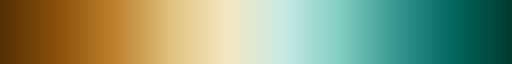

In [11]:
BrBG_10.mpl_colormap

Now let's apply the colormap on `normalized_download_speed` using a helper provided by `lonboard`. We can set it on `layer.get_fill_color` to update the existing colors.

In [19]:
layer.get_fill_color = apply_continuous_cmap(normalized_download_speed, BrBG_10, alpha=0.3)

After running the above cell, you should see the map above update with a different color per point!

We can pass an array into any of the "accessors" supported by the layer (this is any attribute that starts with `get_*`).

For demonstration purposes, let's also set `get_radius` to `normalized_download_speed`.

In [13]:
# for now, cast to a numpy array until the layer is updated to support pandas series
layer.get_radius = np.array(normalized_download_speed) * 200
layer.radius_units = "meters"
layer.radius_min_pixels = 0.5

After running the above cell, you should see the map updated to have a different radius per point!